# Analysis of disagreements

In this series of experiments, we use ablation studies to investigate the role of components highlighted by either Integrated Gradients or activation patching, but not both.

In [1]:
# Set up

%load_ext autoreload
%autoreload 2

import torch
import random
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name
import numpy as np
import matplotlib.pyplot as plt

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, identify_outliers, average_correlation, measure_overlap, test_single_ablated_performance, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [27]:
# Measure baseline performance

test_dataset = TaskDataset(Task.IOI)
test_dataloader = test_dataset.to_dataloader(batch_size=10)

baseline_scores = []

for i, (clean_input, _, labels) in enumerate(test_dataloader):
    clean_tokens = model.to_tokens(clean_input)
    logits = model(clean_tokens)
    baseline_scores += logit_diff_metric(logits, labels)

baseline_performance = sum(baseline_scores) / len(baseline_scores)

In [4]:
ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

## Identify disagreements

In [ ]:
# Identify statistically significant outlier components

scaled_ig_attn = ig_attn * 1e5
attn_outliers = identify_outliers(scaled_ig_attn[0], ap_attn[0])
mlp_outliers = identify_outliers(ig_mlp[0], ap_mlp[0])

In [19]:
# Get the mean activations over a corrupt dataset

attn_outlier_hooks = [get_act_name("result", layer_idx) for layer_idx, _ in attn_outliers]
mlp_outlier_hooks = [get_act_name("post", layer_idx) for layer_idx, _ in mlp_outliers]

random_dataloader = test_dataset.to_dataloader(batch_size=100, shuffle=True)
random_prompts, _, _ = next(iter(random_dataloader))

prompts_tokens = model.to_tokens(random_prompts)
_, prompt_cache = model.run_with_cache(
    prompts_tokens, 
    names_filter=lambda x: x in attn_outlier_hooks or x in mlp_outlier_hooks
)

mean_corrupt_activations = {}
for key in prompt_cache.keys():
    mean_values_over_prompts = torch.mean(prompt_cache[key], dim=0, keepdim=True)
    mean_corrupt_activations[key] = torch.mean(mean_values_over_prompts, dim=1, keepdim=True)

## Performance under isolated ablation

- Hypothesis: components which have high attribution scores in only one of the two methods are still important.
- Method: we measure the performance of a GPT2-small model when the components which are exclusive to only one method are ablated (with mean corrupt activations), one at a time.

### Attention heads

In [ ]:
attn_outlier_isolated_ablation_scores = dict()

for layer, idx in attn_outliers:
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    attn_outlier_isolated_ablation_scores[(layer, idx)] = score

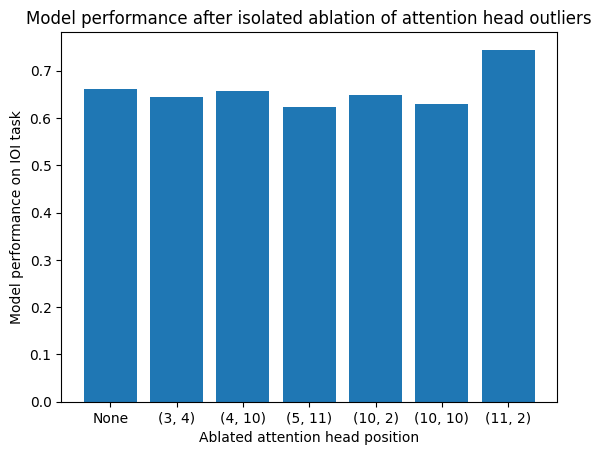

In [30]:
plt.title("Model performance after isolated ablation of attention head outliers")
plt.xlabel("Ablated attention head position")
plt.ylabel("Model performance on IOI task")

xs = ["None"] + [str(k) for k in attn_outlier_isolated_ablation_scores.keys()]
ys = [baseline_performance.item()] + [v.item() for v in attn_outlier_isolated_ablation_scores.values()]

plt.bar(xs, ys)
plt.show()

### Neurons

In [ ]:
mlp_outlier_isolated_ablation_scores = dict()

for layer, idx in mlp_outliers:
    score = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    mlp_outlier_isolated_ablation_scores[(layer, idx)] = score

Test IOI performance with ablated (0, 0)
Mean performance: 0.6607276201248169
Test IOI performance with ablated (0, 3)
Mean performance: 0.6611310839653015
Test IOI performance with ablated (0, 5)
Mean performance: 0.66050124168396
Test IOI performance with ablated (0, 31)
Mean performance: 0.6603237390518188
Test IOI performance with ablated (0, 34)
Mean performance: 0.6603350043296814
Test IOI performance with ablated (0, 36)
Mean performance: 0.6610158681869507
Test IOI performance with ablated (0, 44)
Mean performance: 0.6599968671798706
Test IOI performance with ablated (0, 64)
Mean performance: 0.659958004951477
Test IOI performance with ablated (0, 73)
Mean performance: 0.6614630222320557
Test IOI performance with ablated (0, 81)
Mean performance: 0.6602489352226257
Test IOI performance with ablated (0, 88)
Mean performance: 0.6615949273109436
Test IOI performance with ablated (0, 89)
Mean performance: 0.6613864898681641
Test IOI performance with ablated (0, 115)
Mean performanc

In [ ]:
plt.title("Model performance after isolated ablation of neuron outliers")
plt.xlabel("Ablated neuron position")
plt.ylabel("Model performance on IOI task")

xs = ["None"] + [str(k) for k in mlp_outlier_isolated_ablation_scores.keys()]
ys = [baseline_performance.item()] + [v.item() for v in mlp_outlier_isolated_ablation_scores.values()]

plt.bar(xs, ys)
plt.show()

## Performance under simultaneous ablation

- Hypothesis: components which have high attribution scores in only one of the two methods may be involved in multi-component interactions.
- Method: we measure the performance when the components exclusive to only one method are ablated all at once.

In [ ]:
# Ablate method-exclusive components

outlier_attn_multi_ablated_performance = test_multi_ablated_performance(model, attn_outliers, mean_corrupt_activations, Task.IOI, is_attn=True)

In [ ]:
# Ablate all IG-highlighted components
ig_attn_highlighted, ig_attn_indices = highlight_components(ig_attn)
ig_attn_multi_ablated_performance = test_multi_ablated_performance(model, ig_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# Ablate all AP-highlighted components
ap_attn_highlighted, ap_attn_indices = highlight_components(ap_attn)
ap_attn_multi_ablated_performance = test_multi_ablated_performance(model, ap_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

# Ablate all IG and AP highlighted components
shared_attn_indices = (ig_attn_highlighted & ap_attn_highlighted).nonzero()
shared_attn_multi_ablated_performance = test_multi_ablated_performance(model, shared_attn_indices, mean_corrupt_activations, Task.IOI, is_attn=True)

In [ ]:
plt.title("Model performance after simultaneous ablation of attention heads")
plt.xlabel("Method(s) to highlight ablated attention heads")
plt.ylabel("Model performance on IOI task")

xs = ["None", "IG", "AP", "IG + AP", "Exclusive" ]
ys = [baseline_performance.item(), ig_attn_multi_ablated_performance.item(), ap_attn_multi_ablated_performance.item(), shared_attn_multi_ablated_performance.item(), outlier_attn_multi_ablated_performance.item()]

plt.bar(xs, ys)
plt.show()

### Neurons

In [ ]:
# Ablate method-exclusive components
outlier_mlp_multi_ablated_performance = test_multi_ablated_performance(model, mlp_outliers, mean_corrupt_activations, Task.IOI, is_attn=False)

In [ ]:
# Ablate all IG-highlighted components
ig_mlp_highlighted, ig_mlp_indices = highlight_components(ig_mlp)
ig_mlp_multi_ablated_performance = test_multi_ablated_performance(model, ig_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

# Ablate all AP-highlighted components
ap_mlp_highlighted, ap_mlp_indices = highlight_components(ap_mlp)
ap_mlp_multi_ablated_performance = test_multi_ablated_performance(model, ap_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

# Ablate all IG and AP highlighted components
shared_mlp_indices = (ig_mlp_highlighted & ap_mlp_highlighted).nonzero()
shared_mlp_multi_ablated_performance = test_multi_ablated_performance(model, shared_mlp_indices, mean_corrupt_activations, Task.IOI, is_attn=False)

In [ ]:
plt.title("Model performance after simultaneous ablation of neurons")
plt.xlabel("Method(s) to highlight ablated neurons")
plt.ylabel("Model performance on IOI task")

xs = ["None", "IG", "AP", "IG + AP", "Exclusive" ]
ys = [baseline_performance.item(), ig_mlp_multi_ablated_performance.item(), ap_mlp_multi_ablated_performance.item(), shared_mlp_multi_ablated_performance.item(), outlier_mlp_multi_ablated_performance.item()]

plt.bar(xs, ys)
plt.show()